# Detector to isolate the calls in the training dataset

In [1]:
#Python Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import functools
import time
from tqdm import tqdm
import warnings
import platform
warnings.filterwarnings('ignore')

#ML Imports
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
import torch.nn as nn
import timm
import albumentations as A
import torchaudio

#Audio Imports
import librosa as lb
import gc

In [2]:
in_kaggle = os.environ.get('PWD') == '/kaggle/working'
in_windows = platform.system() == 'Windows'
in_linux = platform.system() == 'Linux'

if not in_kaggle and in_linux:
    working = "/home/olly/Desktop/BirdCLEF23/Kaggle_Kernel/"
elif in_windows:
    working = "C:/Users/ollyp/Desktop/BirdClef23/Kaggle_Kernel"

os.chdir(working) # Set to folder containing the data files
print("Current working directory: {0}".format(os.getcwd()))
print(working)

Current working directory: C:\Users\ollyp\Desktop\BirdClef23\Kaggle_Kernel
C:/Users/ollyp/Desktop/BirdClef23/Kaggle_Kernel


In [3]:
class Config:
    YEAR = 23
    EXPERIMENT = 65
    OUT_DIR = f'kaggle/working/call_detects_{YEAR}_{EXPERIMENT}/'
    OUT_CSV =  OUT_DIR + f'detect_labels_{YEAR}.csv'
    NUM_CLASSES = 264 
    IMAGE_SIZE = 256
    SEED = 2023
    MODEL = 'tf_efficientnetv2_s_in21k'
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
    DATA_PATH = 'kaggle/input/birdclef-2023/train_metadata.csv'
    DATA_PARENT = 'kaggle/input/birdclef-2023/train_audio/' 
    SR = 32000
    DURATION = 5
    MODEL_CKPT = 'kaggle/input/birdclef23_best_weights/exp-64.ckpt'

In [4]:
class Audio:
    SR = 32000
    DURATION = 5
    STEP = 3 # Seconds between each audio sample to be evaluated
    N_MELS = 128 # Try increasing this to 256 later, once other experiments tried
    FMIN = 20
    FMAX = 14000
    WINDOW = 1024  
    HOP_LENGTH = 312
    N_FFT = 1024
    #Goal: 5 second chunks, hopping along in 3 second intervals means that any two consecutive add up to 8 seconds.

In [5]:
os.makedirs(Config.OUT_DIR, exist_ok=True)
pl.seed_everything(Config.SEED, workers=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_flush_denormal(True)
bird_names = sorted(os.listdir('kaggle/input/birdclef-2023/train_audio/'))
bird_names.append('no-call')
bird_names.sort()

Config.NUM_CLASSES = len(bird_names)
nocall_idx = bird_names.index("no-call")
print(f'The index of the no-call class is {nocall_idx}')

Global seed set to 2023


The index of the no-call class is 152


In [6]:
in_csv_fields = ['primary_label', 'secondary_labels', 'type', 'filename']
csv_datatypes = {'primary_label': str, 'secondary_labels': str, 'type': str, 'filename': str}
in_df = pd.read_csv(Config.DATA_PATH,  usecols=in_csv_fields, dtype=csv_datatypes, index_col=None)
in_df['filepath'] = in_df['filename'].apply(lambda x: Config.DATA_PARENT + x)
in_df = in_df.drop('filename', axis=1).reset_index(drop=True)
print(f'The dataframe has shape {in_df.shape}')
in_df.head()

The dataframe has shape (16941, 4)


,primary_label,secondary_labels,type,filepath
0,abethr1,[],['song'],kaggle/input/birdclef-2023/train_audio/abethr1...
1,abethr1,[],['call'],kaggle/input/birdclef-2023/train_audio/abethr1...
2,abethr1,[],['song'],kaggle/input/birdclef-2023/train_audio/abethr1...
3,abethr1,[],['song'],kaggle/input/birdclef-2023/train_audio/abethr1...
4,abethr1,[],"['call', 'song']",kaggle/input/birdclef-2023/train_audio/abethr1...


In [7]:
#decorator to time different fuctions
def timer(func):
    """Print the runtime of the decorated function"""
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        start_time = time.perf_counter()    # 1
        value = func(*args, **kwargs)
        end_time = time.perf_counter()      # 2
        run_time = end_time - start_time    # 3
        print(f"Finished {func.__name__!r} in {run_time:.4f} secs")
        return value
    return wrapper_timer


def compute_melspec(y, 
                    sr=Audio.SR,  
                    n_mels=Audio.N_MELS, 
                    n_fft=Audio.N_FFT, 
                    hop_length = Audio.HOP_LENGTH, 
                    fmin=Audio.FMIN, 
                    fmax=Audio.FMAX): 
    
    melspec = lb.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmin=fmin, fmax=fmax, hop_length=hop_length)
    melspec = lb.power_to_db(melspec).astype(np.float32)
    return melspec


def mono_to_color(X, eps=1e-6, mean=None, std=None): # Normalize to [0, 1]
    _min, _max = X.min(), X.max()
    if (_max - _min) > eps:
        X = (X - _min) / (_max - _min) #scales them onto a range of 1.
        X = X.astype(np.float32)
    else:
        X = np.zeros_like(X, dtype=np.float32)
    return X



def crop_or_pad(y, length, is_train=True, start=None):
    if len(y) < length:
        y = np.concatenate([y, np.zeros(length - len(y))])
        n_repeats = length // len(y)
        epsilon = length % len(y)
        y = np.concatenate([y]*n_repeats + [y[:epsilon]]) 
    elif len(y) > length:
        if not is_train:
            start = start or 0
        else:
            start = start or np.random.randint(len(y) - length)
        y = y[start:start + length]
    return y


def reshape_image(arr):  #chop the image in half along the horizontal dimension and stack to make more square
    cols = arr.shape[1]//2 
    remainder = arr.shape[1] % 2
    half1 = arr[:, :cols + remainder]
    half2 = arr[:, cols:]
    arr =  np.vstack((half1, half2))
    return arr

In [8]:
def normalize_audio(y):
    max_vol = np.abs(y).max()
    y = y * 1 / max_vol
    return(y)
    

mean = (0.485, 0.456, 0.406) # RGB
std = (0.229, 0.224, 0.225) # RGB

albu_transforms = {'valid' : A.Compose([
                A.Normalize(mean, std, max_pixel_value=1.0,always_apply=True),
                A.PadIfNeeded(min_height=Config.IMAGE_SIZE, min_width=Config.IMAGE_SIZE),
                A.RandomCrop(width=Config.IMAGE_SIZE, height=Config.IMAGE_SIZE)])}

In [9]:
class WaveformDataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.df = df
        self.sr = Audio.SR
        self.n_mels = Audio.N_MELS
        self.fmin = Audio.FMIN
        self.fmax = Audio.FMAX
        self.duration = Audio.DURATION
        self.audio_length = self.duration*self.sr
        self.step = Audio.STEP*self.sr
        self.res_type = "kaiser_fast"
        
    def __len__(self):
        return self.df.shape[0]
    
    
    def audio_to_image(self, audio):
        audio = normalize_audio(audio)
        image = compute_melspec(audio)
        image = reshape_image(image)
        image = mono_to_color(image)
        image = np.stack([image, image, image], axis=-1) #puts the chanels last, like a normal image, for the ablu_trasformations
        image = albu_transforms['valid'](image=image)['image']#[:,:,0]
        image = image.transpose(2,0,1).astype(np.float32) # swapping the image channels to the first axis
        return image
    
    
    def read_file(self, filepath):
        audio, orig_sr = torchaudio.load(filepath)
        audio = audio.squeeze().numpy()

        if orig_sr != self.sr:
            audio = lb.resample(audio, orig_sr, self.sr, res_type=self.res_type)

        if len(audio) < self.audio_length:
            concat_arr = audio
            num_missing = (self.audio_length - len(audio))//len(audio) + 1
            for i in range(num_missing):
                concat_arr = np.concatenate((concat_arr, audio), axis=0)
            audio = concat_arr

        audios = []
        starts = []
        for i in range(self.audio_length, len(audio) + self.audio_length, self.step):
            start = max(0, i - self.audio_length)
            end = start + self.audio_length
            audios.append(audio[start:end])
            starts.append(start//self.sr)
            
        if len(audios[-1]) < self.audio_length:
            audios = audios[:-1]
        images = [self.audio_to_image(audio) for audio in audios] 
        images = np.stack(images)   # Stacks the list of 3d arrays, into a single 4d array
        return images, starts
    
        
    def __getitem__(self, idx):
        images, starts = self.read_file(self.df.loc[idx, "filepath"])
        return images, idx, starts

In [10]:
ds_test = WaveformDataset(in_df)
example_image, example_idx, example_starts = ds_test[25]
print(f'The shape of the 25th image, from the first sound file: {example_image[3][0].shape}')
print(f'The number of files in the dataset {len(ds_test)}')
print(f'The index of the 25th image is {example_idx}')
print(f'There are {len(example_starts)} 5 second clips made from this file')

The shape of the 25th image, from the first sound file: (256, 256)
The number of files in the dataset 16941
The index of the 25th image is 25
There are 20 5 second clips made from this file


In [11]:
def show_batch(img_ds, num_rows, num_cols):
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, sharex=True, figsize=(15, 4*num_rows))
    fig.tight_layout(pad=3.0)
    img_inds = np.random.randint(0, in_df.shape[0] -1, num_rows*num_cols)
    for index, ax in zip(img_inds, axes.flatten()):  # list first few images
        
        img, idx, _ = img_ds[index]
        img = img[0][0]
        shape=img.shape
        scaled_data = (img - np.min(img)) / (np.max(img) - np.min(img))
        img = lb.display.specshow(scaled_data, x_axis='time', y_axis='mel', ax=ax)
        bird = in_df.iloc[idx]['primary_label']
        ax.set(title= f'Spectrogram of a {bird} scaled onto [0,1] {shape}')
        fig.colorbar(img, ax=ax, format="%+2.f")        

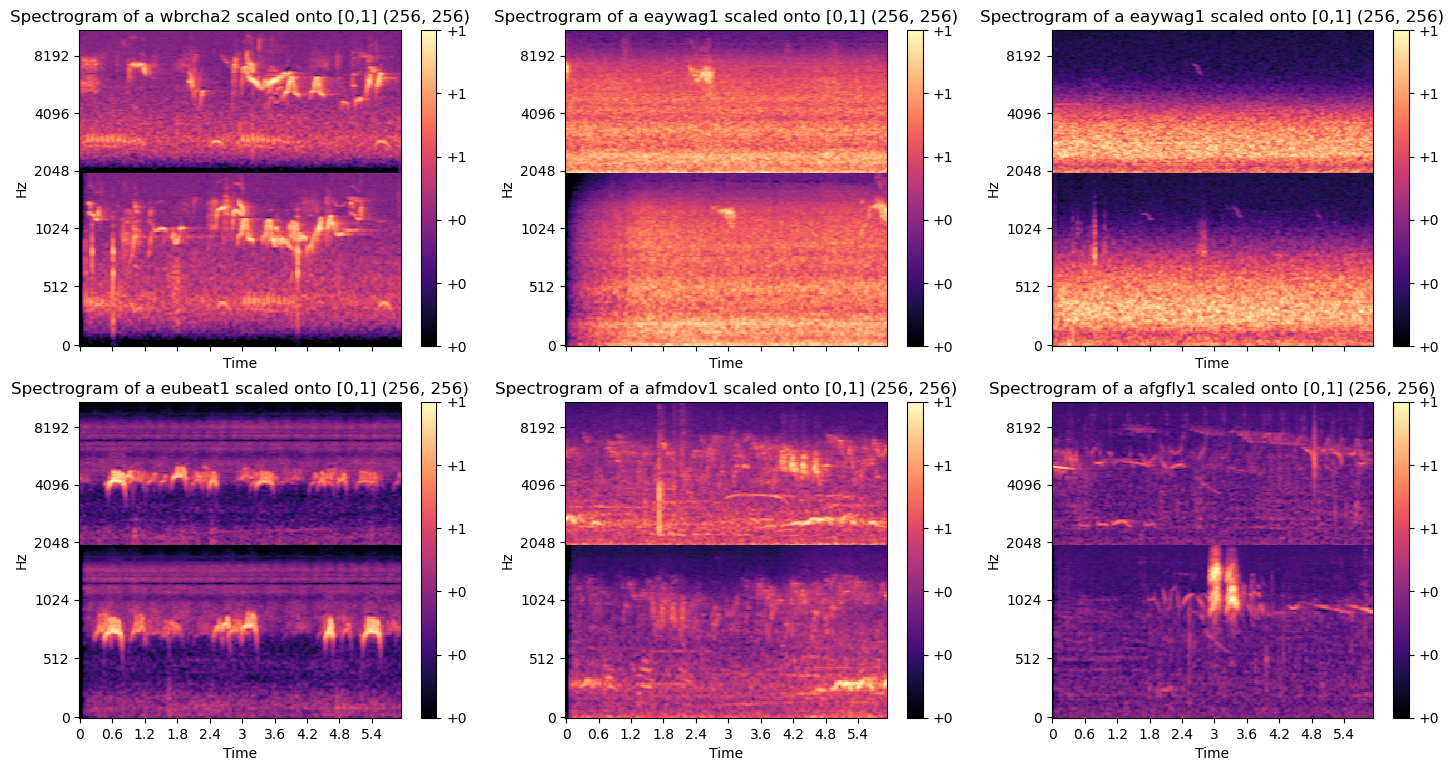

In [12]:
show_batch(ds_test, 2, 3)

In [13]:
class BirdClefModel(pl.LightningModule):
    def __init__(self, model_name=Config.MODEL, num_classes = Config.NUM_CLASSES, pretrained = False):
        super().__init__()
        self.num_classes = num_classes
        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        self.in_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Sequential(nn.Linear(self.in_features, num_classes))

    def forward(self,images):
        logits = self.backbone(images)
        return logits

In [14]:
# There is a possibility here that some long files will create enormous batches & lead to CUDA memory errors
# Consider re-writing to load images in equal sized batches.
@timer
def predict(dataset, model):      
    model.to(device).half()
    model.eval()    
    predictions = {}
    clips = {}
    #for en in tqdm(range(10)):
    for en in tqdm(range(len(ds_test))):
        images, idx, starts = dataset[en]
        images = torch.from_numpy(images).to(device).half()
        with torch.no_grad():
            output_probs = model(images).sigmoid().detach().cpu().numpy()   # Use this with BCEloss
            #output_probs = F.softmax(model(images), dim=1).detach().cpu().numpy()  #use with CrossEntropyLoss
            output_probs = np.round(output_probs, decimals=4).astype(np.float16)  #will produce a lot of 0's but that's OK for this 
            filepath = in_df.loc[idx, 'filepath']
            predictions[filepath] = output_probs
            clips[filepath] = starts
        del images  # release the memory associated with the images tensor
        gc.collect()
        torch.cuda.empty_cache()

    return predictions, clips  
# prections are a dict of arrays, one row of the array for each clip, one array for each filepath 
# clips are a dict of start times.  One item for each filepath.  Values are a list of start times, one for each row of the array

In [15]:
print("Model Creation")
model = BirdClefModel.load_from_checkpoint(Config.MODEL_CKPT, train_dataloader=None,validation_dataloader=None) 
print("Running Inference..")
all_preds, all_clips = predict(ds_test, model)   
gc.collect()
torch.cuda.empty_cache()

Model Creation
Running Inference..


100%|██████████| 16941/16941 [2:08:54<00:00,  2.19it/s]  

Finished 'predict' in 7735.4205 secs


### Generate The new labelling CSV
File Path  |   Start Time  |  Primary Label  | Secondary Labels  | Call Type  | Prediction Probabilities 

In [16]:
new_data = []
for filepath in all_preds.keys():
    file_preds = all_preds[filepath]  #This is a numpy array of predictions
    file_preds_list = [row.tolist() for row in file_preds]
    for idx, clip_preds in enumerate(file_preds_list):
        start_time = all_clips[filepath][idx]
        row = in_df.loc[in_df['filepath'] == filepath].iloc[0]
        list_row = [filepath, start_time, row.primary_label, row['secondary_labels'], row['type']] + clip_preds 
        new_data.append(list_row)

columns=['filepath', 'start', 'primary_label', 'secondary_labels', 'type'] + bird_names
df = pd.DataFrame(new_data, columns=columns)
df.head()


,filepath,start,primary_label,secondary_labels,type,abethr1,abhori1,abythr1,afbfly1,afdfly1,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
0,kaggle/input/birdclef-2023/train_audio/abethr1...,0,abethr1,[],['song'],0.042603,0.001300,0.000900,0.0001,0.0008,...,0.0001,0.002199,0.001100,0.000800,0.0002,0.0003,0.0001,0.0002,0.0001,0.0001
1,kaggle/input/birdclef-2023/train_audio/abethr1...,3,abethr1,[],['song'],0.010002,0.000200,0.000400,0.0000,0.0002,...,0.0000,0.000400,0.000200,0.000100,0.0001,0.0005,0.0001,0.0001,0.0000,0.0000
2,kaggle/input/birdclef-2023/train_audio/abethr1...,6,abethr1,[],['song'],0.015198,0.000700,0.002199,0.0001,0.0007,...,0.0001,0.000800,0.000900,0.000400,0.0001,0.0010,0.0002,0.0001,0.0002,0.0001
3,kaggle/input/birdclef-2023/train_audio/abethr1...,9,abethr1,[],['song'],0.048004,0.001600,0.001300,0.0001,0.0003,...,0.0001,0.000700,0.000900,0.000400,0.0001,0.0005,0.0002,0.0002,0.0001,0.0000
4,kaggle/input/birdclef-2023/train_audio/abethr1...,12,abethr1,[],['song'],0.054688,0.005699,0.000500,0.0003,0.0008,...,0.0004,0.005299,0.002001,0.002001,0.0008,0.0015,0.0007,0.0008,0.0003,0.0003


In [17]:
df.to_csv(Config.OUT_CSV, index=False)